# Machine Predictive Maintenance Classification

This notebook builds a neural network using TensorFlow to predict machine failures based on sensor data. The dataset contains various machine parameters and failure indicators that help predict when maintenance is required.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## Download Dataset

The dataset is downloaded from Kaggle using the kagglehub library. It contains machine sensor readings and failure labels for predictive maintenance analysis.

In [2]:
import kagglehub

path = kagglehub.dataset_download("shivamb/machine-predictive-maintenance-classification")
print("Path to dataset files:", path)

100%|██████████| 137k/137k [00:00<00:00, 51.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/shivamb/machine-predictive-maintenance-classification/versions/1


## Load and Explore Data

The dataset contains multiple features including air temperature, process temperature, rotational speed, torque, and tool wear. The target variable indicates whether a machine failure occurred.

In [3]:
import os

csv_file = os.path.join(path, "predictive_maintenance.csv")
df = pd.read_csv(csv_file)
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (10000, 10)

Column names:
['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']

First few rows:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


## Data Preprocessing

We select the numerical features relevant for prediction and encode any categorical variables. The target variable is the binary failure indicator.

In [4]:
le = LabelEncoder()
df['Type_encoded'] = le.fit_transform(df['Type'])

feature_columns = ['Air temperature [K]', 'Process temperature [K]',
                   'Rotational speed [rpm]', 'Torque [Nm]',
                   'Tool wear [min]', 'Type_encoded']

X = df[feature_columns].values
Y = df['Target'].values.reshape(-1, 1)

print("Features shape:", X.shape)
print("Target shape:", Y.shape)
print("\nTarget distribution:")
print("No Failure:", np.sum(Y == 0))
print("Failure:", np.sum(Y == 1))

Features shape: (10000, 6)
Target shape: (10000, 1)

Target distribution:
No Failure: 9661
Failure: 339


## Normalize Data

Normalization scales features to have similar ranges, which helps the neural network train more efficiently. We use the Keras Normalization layer to learn the mean and variance from the training data.

In [5]:
print("Feature statistics before normalization:")
for i, col in enumerate(feature_columns):
    print(f"{col}: Max={np.max(X[:,i]):.2f}, Min={np.min(X[:,i]):.2f}")

norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)
Xn = norm_l(X)

print("\nFeature statistics after normalization:")
for i, col in enumerate(feature_columns):
    print(f"{col}: Max={np.max(Xn[:,i]):.2f}, Min={np.min(Xn[:,i]):.2f}")

Feature statistics before normalization:
Air temperature [K]: Max=304.50, Min=295.30
Process temperature [K]: Max=313.80, Min=305.70
Rotational speed [rpm]: Max=2886.00, Min=1168.00
Torque [Nm]: Max=76.60, Min=3.80
Tool wear [min]: Max=253.00, Min=0.00
Type_encoded: Max=2.00, Min=0.00

Feature statistics after normalization:
Air temperature [K]: Max=2.25, Min=-2.35
Process temperature [K]: Max=2.56, Min=-2.90
Rotational speed [rpm]: Max=7.51, Min=-2.07
Torque [Nm]: Max=3.67, Min=-3.63
Tool wear [min]: Max=2.28, Min=-1.70
Type_encoded: Max=1.33, Min=-2.00


## Train-Test Split

We split the data into training and testing sets to evaluate model performance on unseen data. A test size of 20% is used.

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(Xn.numpy(), Y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, Y_train.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: (8000, 6) (8000, 1)
Test set shape: (2000, 6) (2000, 1)


## TensorFlow Model

We build a neural network with multiple hidden layers. The architecture uses ReLU activation for hidden layers and sigmoid for the output layer since this is a binary classification problem.

In [8]:
tf.random.set_seed(1234)

model = Sequential([
    tf.keras.Input(shape=(6,)),
    Dense(16, activation='relu', name='layer1'),
    Dense(8, activation='relu', name='layer2'),
    Dense(4, activation='relu', name='layer3'),
    Dense(1, activation='sigmoid', name='output')
])

## Model Summary

The summary shows the architecture of the network including the number of parameters in each layer. The total number of trainable parameters determines the model complexity.

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289 (1.13 KB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

## Compile Model

We use binary crossentropy as the loss function for binary classification. The Adam optimizer with a learning rate of 0.001 is used for training. We also track accuracy as a metric.

In [10]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

## Train Model

The model is trained using the training data. We use a validation split to monitor performance during training and early stopping to prevent overfitting.

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6553 - loss: 0.5714 - val_accuracy: 0.9588 - val_loss: 0.1964
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9666 - loss: 0.1711 - val_accuracy: 0.9588 - val_loss: 0.1519
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9668 - loss: 0.1343 - val_accuracy: 0.9588 - val_loss: 0.1320
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9683 - loss: 0.1119 - val_accuracy: 0.9625 - val_loss: 0.1181
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9693 - loss: 0.0955 - val_accuracy: 0.9644 - val_loss: 0.1105
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9724 - loss: 0.0876 - val_accuracy: 0.9663 - val_loss: 0.1064
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9732 - loss: 0.0831 - val_accuracy: 0.9675 - val_loss: 0.1035
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9750 - loss: 0.0793 - val_accu

## Training History Visualization

Plotting the training and validation loss and accuracy helps identify if the model is overfitting or underfitting.

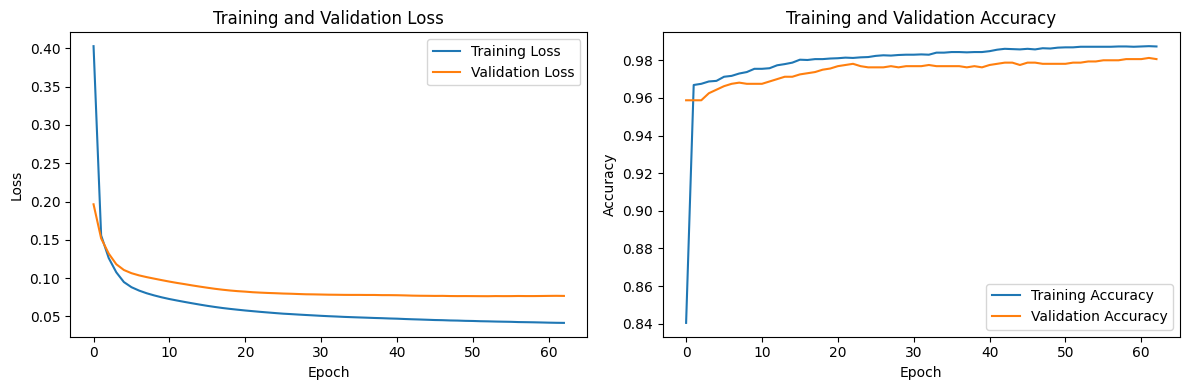

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## Model Evaluation

We evaluate the trained model on the test set to get an unbiased estimate of its performance on unseen data.

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0629
Test Accuracy: 0.9785


## Predictions

We generate predictions on the test set and convert probabilities to binary decisions using a threshold of 0.5.

In [14]:
predictions = model.predict(X_test)
print("Sample predictions (probabilities):")
print(predictions[:10].flatten())

yhat = (predictions >= 0.5).astype(int)
print("\nSample predictions (binary):")
print(yhat[:10].flatten())

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Sample predictions (probabilities):
[1.2542346e-02 8.4240898e-02 2.1433484e-04 6.2794588e-04 6.6592789e-04
 2.3045002e-02 9.6167356e-02 8.0933601e-02 4.9515533e-05 1.4611825e-06]

Sample predictions (binary):
[0 0 0 0 0 0 0 0 0 0]


## Classification Report

The classification report provides precision, recall, and F1-score for each class, giving a comprehensive view of model performance.

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(Y_test, yhat, target_names=['No Failure', 'Failure']))

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      0.99      0.99      1939
     Failure       0.67      0.59      0.63        61

    accuracy                           0.98      2000
   macro avg       0.83      0.79      0.81      2000
weighted avg       0.98      0.98      0.98      2000



## Confusion Matrix

The confusion matrix shows the count of true positives, true negatives, false positives, and false negatives.

In [16]:
cm = confusion_matrix(Y_test, yhat)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1921   18]
 [  25   36]]


## Confusion Matrix Visualization

A heatmap visualization of the confusion matrix makes it easier to interpret the results.

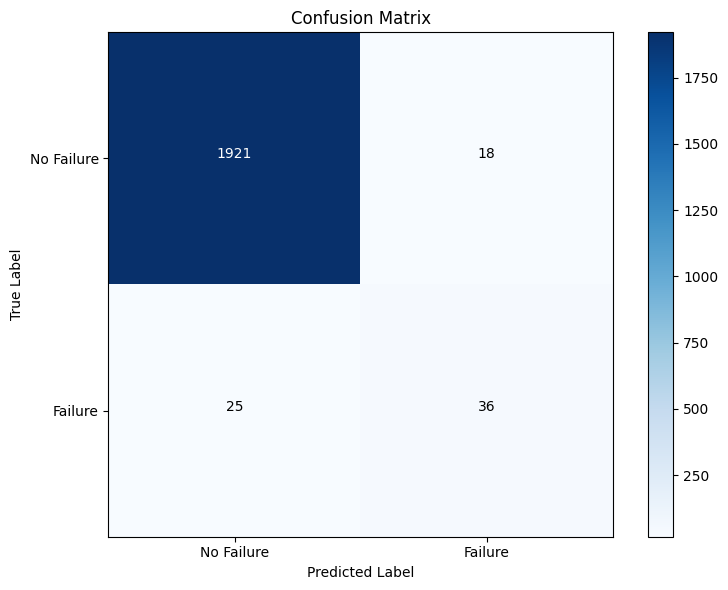

In [17]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Failure', 'Failure'])
plt.yticks(tick_marks, ['No Failure', 'Failure'])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Feature Importance Analysis

We analyze feature importance by examining the weights of the first layer. Features with larger absolute weights have more influence on the model predictions.

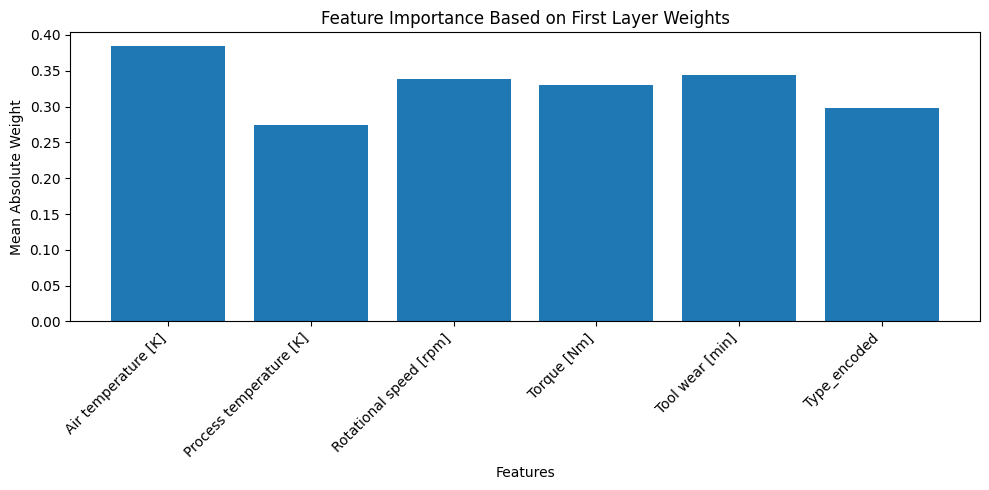

In [18]:
W1, b1 = model.get_layer("layer1").get_weights()
feature_importance = np.mean(np.abs(W1), axis=1)

plt.figure(figsize=(10, 5))
plt.bar(feature_columns, feature_importance)
plt.xlabel('Features')
plt.ylabel('Mean Absolute Weight')
plt.title('Feature Importance Based on First Layer Weights')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Sample Predictions with Original Data

We examine some sample predictions alongside the original feature values to understand the model behavior.

In [19]:
sample_indices = np.random.choice(len(X_test), 5, replace=False)

print("Sample Predictions:")
print("-" * 80)
for idx in sample_indices:
    prob = predictions[idx][0]
    pred = yhat[idx][0]
    actual = Y_test[idx][0]
    print(f"Probability: {prob:.4f} | Predicted: {'Failure' if pred == 1 else 'No Failure'} | Actual: {'Failure' if actual == 1 else 'No Failure'}")

Sample Predictions:
--------------------------------------------------------------------------------
Probability: 0.0007 | Predicted: No Failure | Actual: No Failure
Probability: 0.0000 | Predicted: No Failure | Actual: No Failure
Probability: 0.0001 | Predicted: No Failure | Actual: No Failure
Probability: 0.0000 | Predicted: No Failure | Actual: No Failure
Probability: 0.1214 | Predicted: No Failure | Actual: No Failure


## Model Weights Inspection

Examining the learned weights provides insight into what the neural network has learned from the data.

In [20]:
for layer in model.layers:
    if hasattr(layer, 'get_weights') and len(layer.get_weights()) > 0:
        weights, biases = layer.get_weights()
        print(f"\n{layer.name}:")
        print(f"  Weights shape: {weights.shape}")
        print(f"  Biases shape: {biases.shape}")


layer1:
  Weights shape: (6, 16)
  Biases shape: (16,)

layer2:
  Weights shape: (16, 8)
  Biases shape: (8,)

layer3:
  Weights shape: (8, 4)
  Biases shape: (4,)

output:
  Weights shape: (4, 1)
  Biases shape: (1,)


## Save Model

The trained model is saved for future use. This allows loading the model without retraining.

In [21]:
model.save('predictive_maintenance_model.keras')
print("Model saved successfully.")

Model saved successfully.


## Conclusion

This notebook demonstrated building a neural network for machine predictive maintenance classification. The model was trained to predict equipment failures based on sensor readings including air temperature, process temperature, rotational speed, torque, and tool wear. The classification report and confusion matrix provide detailed insights into model performance.